 # generate movies

---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from dask import delayed
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1)
w = cluster.scale(30)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.36.31:39425 Dashboard: http://10.135.36.31:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

## load grid and data

In [5]:
v = 'Eta'

In [6]:
grd = load_grd()
ds = load_data(v).assign_coords(XC=grd.XC, YC=grd.YC).drop(['Depth','rA', 'hFacC'])
#ds = xr.merge([grd[''],ds])
print(ds)
print('\n data set (all faces): %.1f GB' %(ds.nbytes / 1e9))
print('\n data size (all faces): %.1f GB' %(ds['Eta'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['Eta'].isel(face=1).nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320, time: 8785)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8785,), chunksize=(8785,)>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    iters    (time) int64 dask.array<shape=(8785,), chunksize=(1,)>
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 3.732e+07 3.732e+07
    CS       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    SN       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
Data variables:
    Eta      (time, face, j, i) float32 dask.array<shape=(8785, 13, 4320, 43

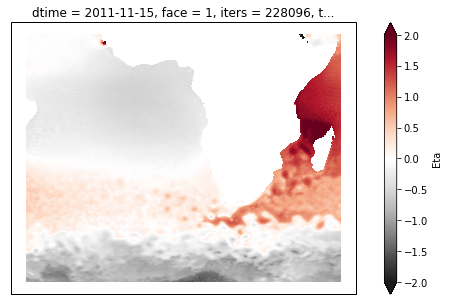

In [7]:
# plot one figure to check lon/lat treatment
dv = ds[v].isel(face=1, time=0)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cmap = cm.curl
cmap = plt.get_cmap('RdGy_r')
dv.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-2., vmax=2., cmap=cmap)

---

# make movie

In [8]:
import pandas as pd
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

_default_cmaps = {'SSU': cm.balance, 'SSV': cm.balance, 
           'Eta': plt.get_cmap('RdGy_r'), 
           'SST': cm.thermal, 'SSS': cm.haline}


def _get_cmap(v, cmap):
    if cmap is None and v.name in _default_cmaps:
        return _default_cmaps[v.name] 
    else:
        return plt.get_cmap('magma')
    
def plot_scalar(v, colorbar=False, title=None, vmin=None, vmax=None, savefig=None, 
                offline=False, coast_resolution='110m', figsize=(10,10), cmap=None):
    #
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        colmap = _get_cmap(v, cmap)
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
        try:
            im = v.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                   x='XC', y='YC', add_colorbar=colorbar, cmap=colmap)
            fig.colorbar(im)
            gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', 
                            alpha=0.5, linestyle='--')
            gl.xlabels_top = False
            if coast_resolution is not None:
                ax.coastlines(resolution=coast_resolution, color='k')
        except:
            pass
        #
        if title is not None:
            ax.set_title(title)
        #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        #if not offline:
        #    plt.show()
        return fig, ax
    
_region_params = {'atlantic': {'faces':[0,1,2,6,10,11,12],'extent':[-110,25,-70,70], 'projection': ccrs.Mollweide()}, 
                  'south-atlantic':{'faces':[1,11,0,12],'extent':[-50,20,-60,5],
                                    'projection': ccrs.LambertAzimuthalEqualArea(central_longitude=-15.,
                                                                                 central_latitude=-30)}}
#                  'south-atlantic':{'faces':[0,1,11,12],'extent':[-100,25,-70,5]},}

def plot_pretty(v, colorbar=False, title=None, vmin=None, vmax=None, savefig=None, 
                offline=False, coast_resolution='110m', figsize=(15,15), cmap=None,
                ignore_face=[], projection=None, extent=None, region=None):
    #
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        colmap = _get_cmap(v, cmap)
        #
        if region is not None:
            _extent = _region_params[region]['extent']
            gen = (face for face in _region_params[region]['faces'] 
                   if face not in ignore_face)
            _projection = _region_params[region]['projection']
        else:
            gen = (face for face in v.face.values if face not in ignore_face)
            _projection = ccrs.Robinson()
        if extent is not None:
            _extent = extent
        if projection is not None:
            _projection = projection
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=_projection)
        ax.set_extent(_extent)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC>0) & (vplt.XC<179.)).plot.pcolormesh(ax=ax,
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=colmap)
                im = vplt.where(vplt.XC<0).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=colmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=colmap)
        #fig.colorbar(im)
        # grid lines:
        gl = ax.gridlines()
        #ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
        #ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
        #lon_formatter = LongitudeFormatter(zero_direction_label=True)
        #lat_formatter = LatitudeFormatter()
        #ax.xaxis.set_major_formatter(lon_formatter)
        #ax.yaxis.set_major_formatter(lat_formatter)        
        # only with platecarre
        #if projection is 'PlateCarre':
        #    gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', 
        #                    alpha=0.5, linestyle='--')
        #    gl.xlabels_top = False
        
        # coastlines and land:
        #if coast_resolution is not None:
        #    ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)
        #
        if title is not None:
            ax.set_title(title,fontdict={'fontsize':20, 'fontweight':'bold'})
        #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        #if not offline:
        #    plt.show()
        return fig, ax

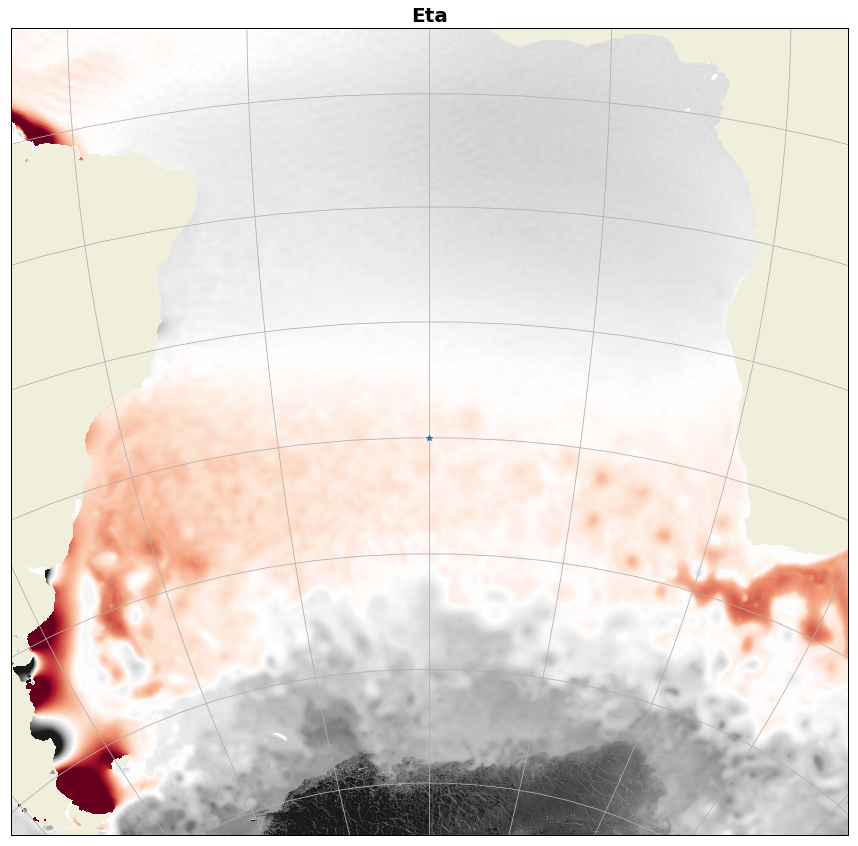

In [9]:
fig, ax = plot_pretty(ds[v].isel(time=0), vmin=-2., vmax=2., region='south-atlantic',
                      title=v)
ax.plot(-15.,-30., '*', transform=ccrs.PlateCarree())
# ccrs.LambertAzimuthalEqualArea(central_longitude=-15.,central_latitude=-30)
# ccrs.AzimuthalEquidistant(central_longitude=-15.,central_latitude=-30)
# ccrs.Stereographic(central_longitude=-15,central_latitude=-30)
#ax.gridlines() # does not show up with transverse mercator

In [10]:
vmin, vmax = -2., 2.

#delete all figures beforehand
figdir = scratch+'figs/'
print('Figures directory: '+figdir)

#face = 1
#lds = ds.isel(face=face)
lds = ds

def genfig(ds, v, i, pretty=True, overwrite=True):
    
    region = 'south-atlantic'
    
    # !! passing the variable does not work
    dv = ds[v]

    #time = pd.to_datetime(str(eta['time'].values))
    #time = dv['time'].values/86400.
    time = pd.to_datetime(dv['dtime'].values)
    #figname = figdir+'%s_f%d_t%05d' %(v, face, i)+'.png'
    figname = figdir+'%s_%s_t%05d' %(v, region, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        #title = 'eta %.2f' %time
        title = '%s %s' %(v, time.strftime('%Y/%m/%d %Hh'))
        if pretty:
            fig, ax = plot_pretty(dv, vmin=vmin, vmax=vmax, region=region,
                                  colorbar=False, title=title, savefig=figname,
                                  offline=True)
        else:
            figs, ax = plot_scalar(dv, vmin=vmin, vmax=vmax, 
                                   colorbar=False, title=title, savefig=figname,
                                   offline=True, coast_resolution=None, figsize=(15,10))
        #
        #m = float(dv.mean().values)
        m = 1.
    else:
        m = -1.
    return m

Figures directory: /home/mp/pontea/scratch/figs/


Process all times

In [ ]:
I = range(len(ds['time']))
I = range(10)
values = [delayed(genfig)(lds.isel(time=i), v, i) for i in I]

In [ ]:
futures = client.compute(values)
%time results = client.gather(futures)

Process a selection of times

In [ ]:
#II = np.array_split(np.arange(len(ds['time'])),len(ds['time'])/20) # 4 maybe will work
rg = range(6000,8000)
II = np.array_split(rg,len(rg)/20) # 4 maybe will work
print('%d loops to be done'%len(II))
for I in II:
    print('%d - %d'%(I[0],I[-1]))
    #lds = ds.isel(time=slice(I[0],I[-1]+1))
    #values = [delayed(genfig)(lds.isel(time=i), v, I[i]) for i in range(len(I))]    
    values = [delayed(genfig)(ds.isel(time=i), v, i, overwrite=False) for i in I]    
    futures = client.compute(values)
    %time results = client.gather(futures)

100 loops to be done
6000 - 6019


```
ffmpeg -f image2 -r 20 -pattern_type glob -i "./figs/*_t00*.png" -q:v 1 ./out.mp4
```

---

# info, shutdown

In [19]:
cluster.close()

In [ ]:
client.restart()